Clustering (or cluster analyis) is a category of unsupervised learning techniques that allows us to find groups of similar objects, objects that are more related to each other than to objects in other groups.

# k-means algoritme

The k-means algorithm belongs to the category of prototype-based clustering. Prototype-based clustering means that each cluster is represented by a prototype, which can either by the centroid (average) of similar points with continuous features, or the medoid (the most representative or most frequently occuring point) in the case of categorical features. We have to specify the number of clusters _k_ a priori.

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import geopandas as gpd
import matplotlib.pyplot as plt

| Variabele     | Omschrijving                                                                        | 
| :------------ |:------------------------------------------------------------------------------------| 
| buurtcode	    | buurtcode                                                                           |    
| buurtnaam	    | buurtnaam                                                                           | 
| won_ha	    | woningdichtheid (aantal woningen per hectare) 2018                                  | 
| wonlabtot     | totaal aantal geldige energielabels woningen (aantal) in 2018                       |            
| wonlabaaa	    | woningen met geldig energielabel A++ (aantal) in 2018                               |     
| wonlabaa	    | woningen met geldig energielabel A+ (aantal) in 2018                                |     
| wonlaba	    | woningen met geldig energielabel A (aantal) in 2018                                 |     
| wonlabb	    | woningen met geldig energielabel B (aantal) in 2018                                 |     
| wonlabc	    | woningen met geldig energielabel C (aantal) in 2018                                 |     
| wonlabd	    | woningen met geldig energielabel D (aantal) in 2018                                 |     
| wonlabe	    | woningen met geldig energielabel E (aantal) in 2018                                 |     
| wonlabf	    | woningen met geldig energielabel F (aantal) in 2018                                 |     
| wonlabg	    | woningen met geldig energielabel G (aantal) in 2018                                 |  
| wbwoz         | gemiddelde WOZ-waarde (dzd. euro) 2018                                              | 
| ink_hh        | gemiddeld inkomen per huishouden (euro) in 2017                                     |  
| aandwb_hh	    | aandeel energiekosten (gas, el. en warmte) in gemiddeld huishoudinkomen (%) in 2017 | 
| wbwonkoop	    | koopwoningen (als % van de woningvoorraad) (%) in 2018                              |  
| wbwonvrdk1	| woningen met bouwjaar tot 2000 (als % van de woningvoorraad) (%)                    |      

In [2]:
df = pd.read_csv('./data/buurten.csv', sep = '\t')

kolommen = ['buurtcode', 'won_ha',                   \
            'wonlabtot', 'wonlabaaa',  'wonlabaa',   \
            'wonlaba',   'wonlabb',    'wonlabc',    \
            'wonlabd',   'wonlabe',    'wonlabf',    \
            'wonlabg',   'wbwoz',      'ink_hh' ,    \
            'aandwb_hh', 'wbwonhuur',  'wbwonkoop',  \
            'wbwoneonb', 'wbwonvrdk1', 'wbwonvrdk2']

# E, F en G worden 'rood' genoemd, omdat huizen met die energielabels veel energie verspillen.
# A en B worden 'groen' genoemd. Deze huizen zijn naar hedendaagse inzichten voldoende energiezuinig.
# C en D noemen we in deze analyse 'oranje'.

# Als het aantal woningen met een bepaald energielabel NaN is, betekent het eigenlijk dat de waarde nul is.

df = df[kolommen] \
    .fillna(0) \
    .assign(energielabel_groen  = lambda x: round((x.wonlabaaa + x.wonlabaa + x.wonlaba + x.wonlabb) / x.wonlabtot, 2)) \
    .assign(energielabel_oranje = lambda x: round((x.wonlabc + x.wonlabd) / x.wonlabtot, 2))                            \
    .assign(energielabel_rood   = lambda x: round((x.wonlabe + x.wonlabf + x.wonlabg) / x.wonlabtot, 2))

# Een gemiddelde WOZ-waarden van 0 euro, betekent eigenlijk dat de WOZ-waarde onbekend is 
# of om privacy redenen niet gedeeld mag worden (NaN).
# Voor een gemiddeld inkomen per huishouden van 0 euro en een aandeel energiekosten in gemiddeld huishouden van 0 %, 
# geldt hetzelfde.

# Als het aandeel koopwoningen 0 % is én het aandeel huurwoningen is 0 % én het aandeel eigendom onbekend is 0 %,
# dan zijn de waarden van beide variabelen eigenlijk onbekend (dus NaN).

# Als het aandeel woningen van vóór 2000 gelijk is aan 0 % én het aandeel woningen van 2000 of later is ook 0 %,
# dan zijn de waarden van beide variabelen eigenlijk onbekend (dus NaN).

df = df \
    .assign(wbwoz      = np.where(df.wbwoz == 0, np.nan, df.wbwoz))                                           \
    .assign(ink_hh     = np.where(df.ink_hh == 0, np.nan, df.ink_hh))                                         \
    .assign(aandwb_hh  = np.where(df.aandwb_hh == 0, np.nan, df.aandwb_hh))                                   \
    .assign(wbwonkoop  = np.where((df.wbwonkoop + df.wbwonhuur + df.wbwoneonb) == 0 , np.nan, df.wbwonkoop))  \
    .assign(wbwonvrdk1 = np.where((df.wbwonvrdk1 + df.wbwonvrdk2) == 0 , np.nan, df.wbwonvrdk1)) 

df.drop(['wonlabtot', 'wonlabaaa', 'wonlabaa', 'wonlaba',   'wonlabb',   'wonlabc',    'wonlabd',   \
         'wonlabe',   'wonlabf',   'wonlabg',  'wbwonhuur', 'wbwoneonb', 'wbwonvrdk2'], axis = 1, inplace = True) 

In [3]:
df.head(10)

,buurtcode,won_ha,wbwoz,ink_hh,aandwb_hh,wbwonkoop,wbwonvrdk1,energielabel_groen,energielabel_oranje,energielabel_rood
0,BU19302902,0.15,403.0,80900.0,0.026,0.93,0.91,0.11,0.44,0.44
1,BU19310003,0.24,403.0,70800.0,0.032,0.72,0.66,0.29,0.14,0.57
2,BU05050801,60.28,96.0,32000.0,0.032,0.33,0.98,0.09,0.55,0.36
3,BU05051909,6.27,234.0,54900.0,0.030,0.83,1.00,0.00,0.40,0.60
4,BU05050106,91.67,139.0,41200.0,0.025,0.39,0.96,0.09,0.76,0.15
5,BU05050107,65.25,155.0,47400.0,0.025,0.51,0.91,0.08,0.48,0.44
6,BU06060308,27.33,203.0,63500.0,0.024,0.60,1.00,0.00,0.39,0.61
7,BU05750005,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,BU05560404,19.50,296.0,75500.0,0.014,0.68,0.00,1.00,0.00,0.00
9,BU06060309,31.21,153.0,51300.0,0.021,0.69,0.75,0.09,0.37,0.54


In [4]:
print(f'''Aantal rijen (inclusief rijen met missende waarden): {df.shape[0]}.''')
df_no_missing = df.copy()
df_no_missing.dropna(thresh = df.shape[1], inplace = True)
print(f'''Aantal rijen zonder missende waarden: {df_no_missing.shape[0]}.''')
print(f'''Er zijn dus {df.shape[0] - df_no_missing.shape[0]} rijen met één of meer missende waarden.''')

Aantal rijen (inclusief rijen met missende waarden): 2186.
Aantal rijen zonder missende waarden: 1657.
Er zijn dus 529 rijen met één of meer missende waarden.


In [5]:
# Vul bij een missende waarde het gemiddelde van de kolom in.
X = df.iloc[:, 1:].copy().values
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp.fit(X)
X_imputed = imp.transform(X)
df_imputed = pd.DataFrame(data = X_imputed, columns = df.columns[1:])

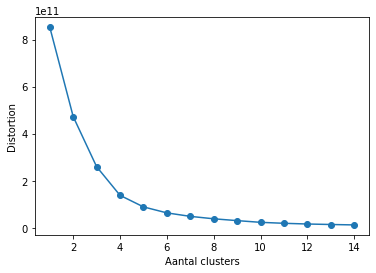

In [6]:
# Bepaal het aantal clusters (k)
distortions = []
for i in range (1, 15):
    km = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, max_iter = 1000, random_state = 0)
    km.fit(df_imputed)
    distortions.append(km.inertia_)
plt.plot(range(1,15), distortions, marker = 'o')
plt.xlabel('Aantal clusters')
plt.ylabel('Distortion')
plt.show()

In [7]:
km = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 1000, tol=1e-04, random_state = 0)
y_km = km.fit_predict(df_imputed)
df['cluster'] = y_km
df['cluster'] = df['cluster'].apply(lambda x: 'cluster ' + str(x))

In [8]:
buurten = pd.merge(gpd.read_file('./data/buurten.shp'), df, on = 'buurtcode', how = 'left')

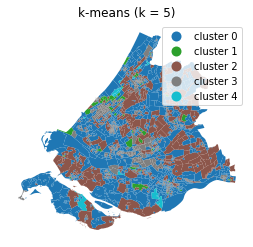

In [9]:
fig, ax = plt.subplots(1, 1)
ax.set_title('k-means (k = 5)')
ax.set_axis_off()
buurten.plot(column = 'cluster', ax = ax, legend = True)

In [11]:
c = ['woningen per ha', 'WOZ waarde (x1000)', 'gemiddeld huishoudinkomen', 'aandeel energiekosten in gemiddeld huishoudinkomen', \
     'koopwoningen als % van de woningvoorraad', 'woningen met bouwjaar tot 2000', \
      'energielabel groen (A++, A+, A of B)', 'energielabel oranje (C of D)', 'energielabel rood (E, F of G)']

out = pd.DataFrame(km.cluster_centers_, columns = c) 
out['aantal buurten'] = np.unique(y_km, return_counts=True)[1]
out = out.style.format({'woningen per ha' : "{:.1f}", 
               'WOZ waarde (x1000)' : "€ {:,.0f}", 
               'gemiddeld huishoudinkomen': "€ {:,.0f}", 
               'aandeel energiekosten in gemiddeld huishoudinkomen': "{:.2%}", 
               'koopwoningen als % van de woningvoorraad': "{:.0%}",
               'woningen met bouwjaar tot 2000': "{:.0%}", 
               'energielabel groen (A++, A+, A of B)': "{:.0%}", 
               'energielabel oranje (C of D)': "{:.0%}", 
               'energielabel rood (E, F of G)': "{:.0%}"})
out

,woningen per ha,WOZ waarde (x1000),gemiddeld huishoudinkomen,aandeel energiekosten in gemiddeld huishoudinkomen,koopwoningen als % van de woningvoorraad,woningen met bouwjaar tot 2000,"energielabel groen (A++, A+, A of B)",energielabel oranje (C of D),"energielabel rood (E, F of G)",aantal buurten
0,14.3,€ 246,"€ 59,718",2.47%,68%,84%,28%,45%,26%,1198
1,11.1,€ 493,"€ 112,920",1.80%,78%,70%,46%,25%,28%,55
2,13.4,€ 328,"€ 78,017",2.19%,81%,72%,45%,35%,20%,401
3,42.3,€ 163,"€ 39,931",2.91%,37%,90%,18%,53%,28%,518
4,2.8,€ 810,"€ 199,214",1.51%,70%,81%,19%,34%,47%,14


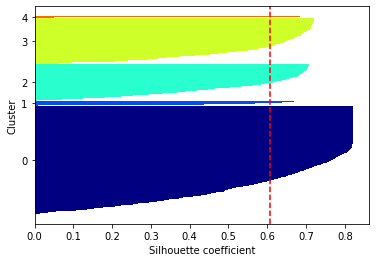

In [12]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(df_imputed, y_km, metric = 'euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate (cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0, edgecolor = 'none', color = color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = "red", linestyle = "--")
plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [17]:
df.iloc[:, 1:-1]

,won_ha,wbwoz,ink_hh,aandwb_hh,wbwonkoop,wbwonvrdk1,energielabel_groen,energielabel_oranje,energielabel_rood
0,0.15,403.0,80900.0,0.026,0.93,0.91,0.11,0.44,0.44
1,0.24,403.0,70800.0,0.032,0.72,0.66,0.29,0.14,0.57
2,60.28,96.0,32000.0,0.032,0.33,0.98,0.09,0.55,0.36
3,6.27,234.0,54900.0,0.030,0.83,1.00,0.00,0.40,0.60
4,91.67,139.0,41200.0,0.025,0.39,0.96,0.09,0.76,0.15
5,65.25,155.0,47400.0,0.025,0.51,0.91,0.08,0.48,0.44
6,27.33,203.0,63500.0,0.024,0.60,1.00,0.00,0.39,0.61
7,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,19.50,296.0,75500.0,0.014,0.68,0.00,1.00,0.00,0.00
9,31.21,153.0,51300.0,0.021,0.69,0.75,0.09,0.37,0.54


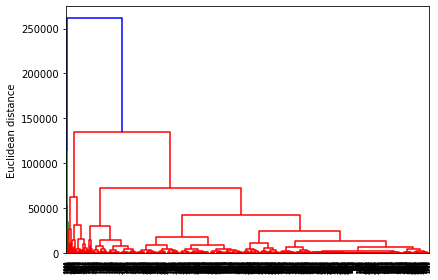

In [28]:
#from scipy.spatial.distance import pdist, squareform
#row_dist = pd.DataFrame(squareform(pdist(df_imputed, metric='euclidean')))
#row_dist
from scipy.cluster.hierarchy import linkage
row_clusters = linkage(df_imputed.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters, columns = ['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
            index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])
from scipy.cluster.hierarchy import dendrogram
row_dendr = dendrogram(row_clusters)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()